In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from scipy import stats

In [6]:
# ===============================
# LOAD DATA
# ===============================
superstore_sales = pd.read_csv("../data/superstore.csv", encoding="latin1", parse_dates=["Order Date"])
walmart_sales = pd.read_csv("../data/train.csv", parse_dates=["Date"])

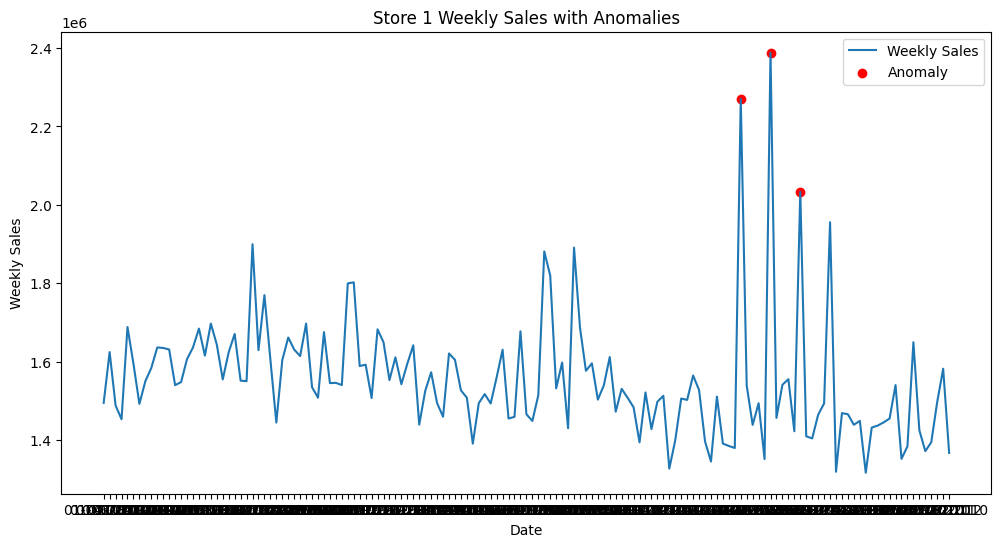

In [7]:
# ===============================
# -------------------------------
# ANOMALY DETECTION - WALMART
# -------------------------------
# Aggregate weekly sales per store
weekly_sales = walmart_sales.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Function to detect anomalies using Z-score
def detect_anomalies(df, col='Weekly_Sales', threshold=3):
    z_scores = np.abs(stats.zscore(df[col]))
    df['Anomaly'] = z_scores > threshold
    return df

store_id = 1  # Example: analyze Store 1
store_sales = weekly_sales[weekly_sales['Store'] == store_id].copy()
store_sales = detect_anomalies(store_sales)

# Plot anomalies
plt.figure(figsize=(12,6))
plt.plot(store_sales['Date'], store_sales['Weekly_Sales'], label='Weekly Sales')
plt.scatter(store_sales['Date'][store_sales['Anomaly']], 
            store_sales['Weekly_Sales'][store_sales['Anomaly']], 
            color='red', label='Anomaly')
plt.title(f'Store {store_id} Weekly Sales with Anomalies')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

18:03:37 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing


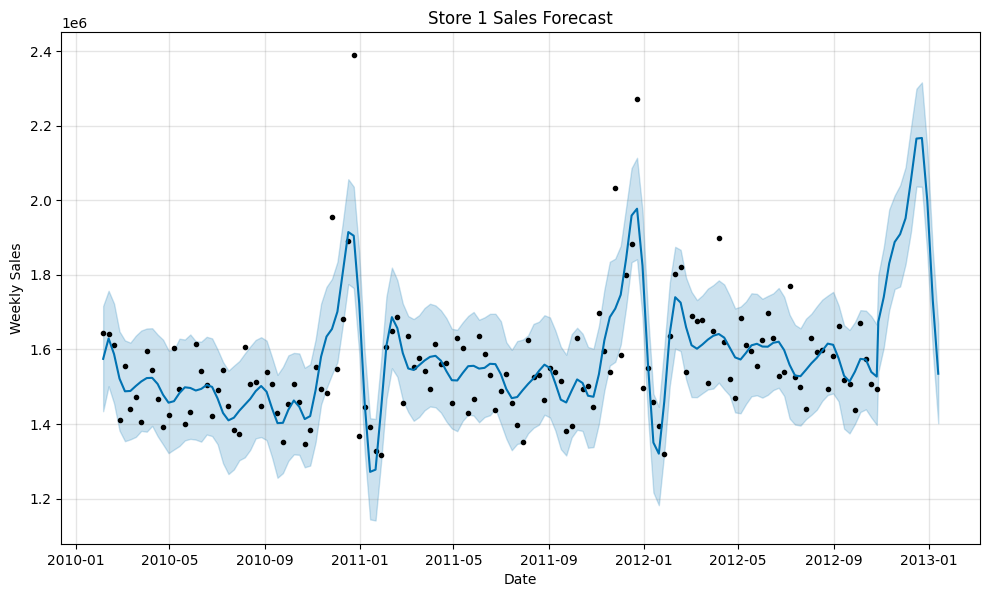

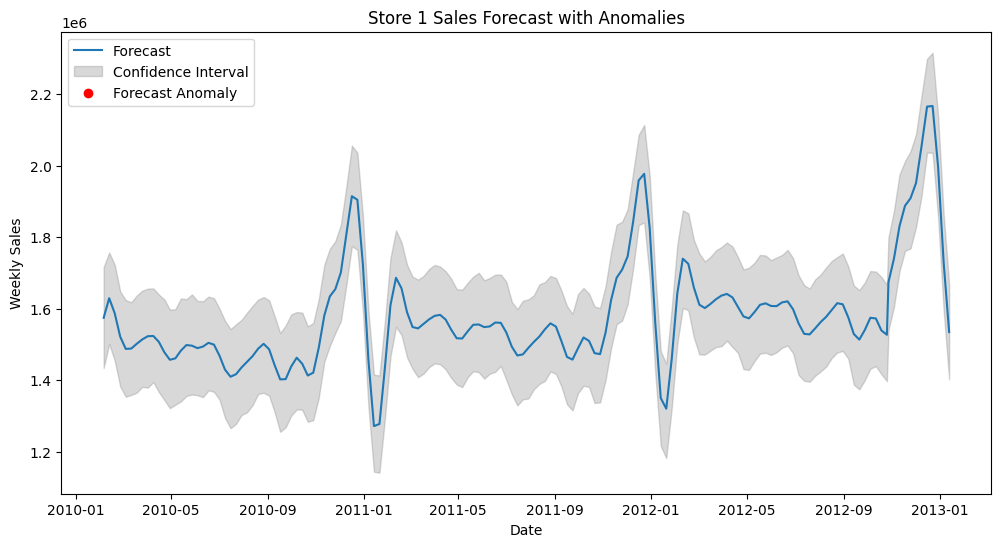

In [9]:
# ===============================
# -------------------------------
# FORECASTING - WALMART (PROPHET)
# -------------------------------

# Ensure 'Date' column is proper datetime, coerce errors
store_sales['Date'] = pd.to_datetime(store_sales['Date'], errors='coerce', dayfirst=True)

# Drop rows where 'Date' could not be parsed
store_sales_prophet = store_sales.dropna(subset=['Date'])[['Date', 'Weekly_Sales']].rename(columns={'Date':'ds', 'Weekly_Sales':'y'})

# Initialize Prophet
m = Prophet(weekly_seasonality=True, daily_seasonality=False)

# Fit the model
m.fit(store_sales_prophet)

# Forecast next 12 weeks
future = m.make_future_dataframe(periods=12, freq='W')
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title(f'Store {store_id} Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

# Highlight forecasted anomalies (outside confidence intervals)
forecast['Anomaly'] = (forecast['yhat'] < forecast['yhat_lower']) | (forecast['yhat'] > forecast['yhat_upper'])
plt.figure(figsize=(12,6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')
plt.scatter(forecast['ds'][forecast['Anomaly']], forecast['yhat'][forecast['Anomaly']], color='red', label='Forecast Anomaly')
plt.title(f'Store {store_id} Sales Forecast with Anomalies')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


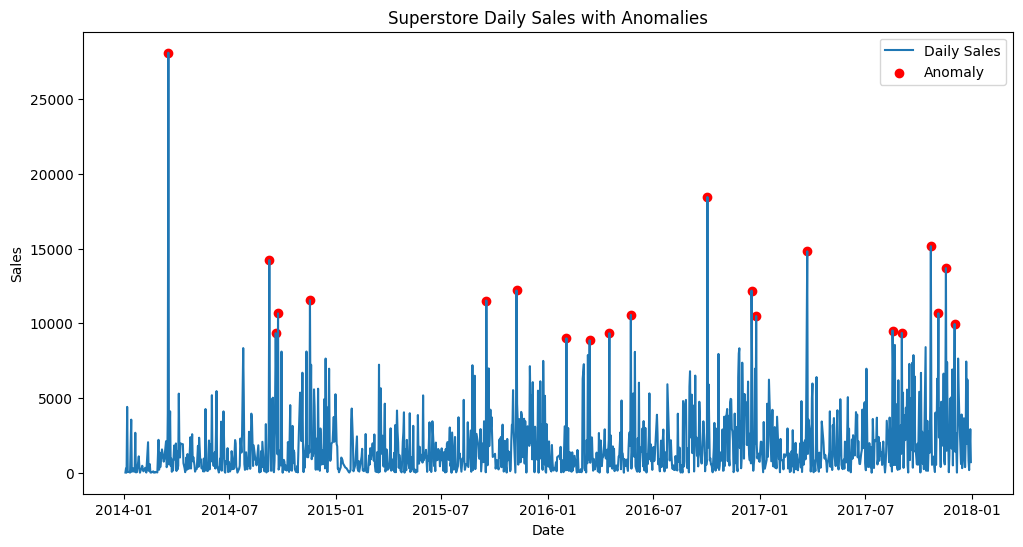

In [10]:
# ===============================
# -------------------------------
# SUPERSTORE SALES ANOMALY
# -------------------------------
# Aggregate daily sales
superstore_daily = superstore_sales.groupby('Order Date')['Sales'].sum().reset_index()
superstore_daily = detect_anomalies(superstore_daily, col='Sales')

plt.figure(figsize=(12,6))
plt.plot(superstore_daily['Order Date'], superstore_daily['Sales'], label='Daily Sales')
plt.scatter(superstore_daily['Order Date'][superstore_daily['Anomaly']], 
            superstore_daily['Sales'][superstore_daily['Anomaly']], 
            color='red', label='Anomaly')
plt.title('Superstore Daily Sales with Anomalies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()